# Training a Smartcab Planner

In the fourth project for the Udacity Machine Learning Nanodegree, I had to [teach a smartcab how to drive]() in a simple, grid-like world. The task consisted mainly in getting the smartcab to learn traffic rules, since a central planner would provide it with the next move - turn left, turn right, or go forward.

A natural next step is to create a learner that comes up with such a planner: an algorithm that, given the difference between the smartcab's location and its destination, would calculate the best next move. This notebook shows how such a planner can be implemented.

## Importing Stuff

Let's begin by importing and configuring some modules to be used later on:

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Building the World

Before we build a learning agent, we need to build the world in which it will operate and the rules that govern it. The functions in this section will calculate the distance between the points (as a tuple and as a scalar), distribute rewards (both positive and negative) to the agent according to its behavior, and move the agent around in a grid-like world. 

### Calculate the Distance

First thing we need is a function that calculates the distance between two points in a grid world. We are talking [Manhattan distance]() here: the smartcab can only turn in straight angles. Another important point is that the world in question is modular, meaning if the smartcab keeps going in a direction it will end up on the other side (for instance, if it keeps going north it will eventually reach the northmost point of the world). With these characteristics in mind, let's build a function that returns a tuple with the West-East and North-South distances between the smartcab's location and its destination.

In [2]:
def get_delta(location, destination, grid_size):
    """
    get the horizontal and vertical distance
    between location and destination.
    """
    delta = [0, 0]
    
    for i in range(2):
        # 1st option: destination to the east/south of location
        if destination[i] > location[i]:
            # two possible distances, going east/south or
            # going west/north
            possible_delta = [destination[i] - location[i], 
                              location[i] + grid_size[i] - destination[i]]
            # if the first distance is the smallest, pick it
            if min(possible_delta) == possible_delta[0]:
                delta[i] = possible_delta[0]
            # if seconde distance is the smallest, pick minus it
            # (the agent will have to go west/north to get to a point
            #  to the east/south)
            else:
                delta[i] = -possible_delta[1]
        # 2nd option: destination to the west/north of location
        else:
            # two possible distances, going west/north or
            # going east/south
            possible_delta = [location[i] - destination[i],
                              destination[i] + grid_size[i] - location[i]]
            # if the first distance is the smallest, pick minus it
            # (the agent will have to go west/north)
            if min(possible_delta) == possible_delta[0]:
                delta[i] = -possible_delta[0]
            # if second distance is smallest, pick it
            else:
                delta[i] = possible_delta[1]
    # return a tuple
    return tuple(delta)

The above function calculates two distances, in two axes. The function below calculates the total distance given a delta:

In [39]:
def get_distance(delta):
    """
    Returns the overall distance.
    """
    return sum([abs(i) for i in delta])

### Coming up with Rewards

For our agent to learn, it needs to be rewarded when it performs well - and punished when it performs poorly. The function below distributes rewards to the agent in the following manner:

- If the agent hasn't reached its destination, the function returns a negative reward equivalent to the distance between the agent's location and its destination
- If the agent has reached its destination, the function returns a positive reward equivalent to the time the agent still had left to arrive

Since the negative reward grows as the distance between location and destination grows, and the positive reward increases as there's more time left (that is, as the agent gets to its destination sooner), this reward system should make our agent learn to get to its destination as fast as possible.

In [40]:
def get_reward(location, destination, grid_size, deadline):
    """
    Returns a negative reward proportional do distance if
    the agent has not reached its destination, and a negative
    reward proportional to the time left if the agent has
    reached its destination.
    """
    delta = get_delta(location, destination, grid_size)
    distance = get_distance(delta)
    if distance:
        reward = -distance
    else:
        reward = deadline
    return reward

This is not the only way to implement rewards for a learning agent. I could, for instance, have given positive rewards for moves that decrease the distance between the agent's location and its destination.

### Moving the Agent Around

I also need a function that will actually get the agent to move in the world. For this, I need to know:

- Where the agent is
- Where it's headed
- How the world is shaped
- What the agent is doing

There are basically four things the agent can do: go forward, turn left, turn right, or do nothing. The way of implementing each action will depend on where the agent is and where it's facing.

In [41]:
def get_next_point(position, heading, grid_size, action):
    """
    Returns the next position and heading the agent will be in.
    """
    next_point = list(position) # to be modified below
    next_heading = list(heading) # to be modified below
    if action == 'forward': # just move according to the heading
        next_point = [(next_point[i] + heading[i]) % grid_size[i]
                      for i in range(2)]
    elif action == 'right':
        if heading[0]: #turned to EW axis
            next_point[1] = (next_point[1] + heading[0]) % grid_size[1]
            next_heading = [heading[1], heading[0]]
        else: # turned to NS axis
            next_point[0] = (next_point[0] - heading[1]) % grid_size[0]
            next_heading = [-heading[1], heading[0]]
    elif action == 'left':
        if heading[0]: # turned to EW axis
            next_point[1] = (next_point[1] - heading[0]) % grid_size[1]
            next_heading = [heading[1], -heading[0]]
        else: # turned to NS axis
            next_point[0] = (next_point[0] + heading[1]) % grid_size[0]
            next_heading = [heading[1], heading[0]]
    elif action != None:
        raise ValueError('Invalid action.')
    
    # check if agent has gone to the other side of the world
    next_point = [grid_size[i] if next_point[i] == 0 else next_point[i]
                  for i in range(2)]

    return tuple(next_point), tuple(next_heading)

## Simulate the World

Now that I've built the functions needed for this world to work, it's time to actually simulate it.

### Global Variables

I'll define first some global variables for this world: the size of the grid, the possible actions the agent can make, the number of trials it will have to learn from, and the deadline to reach its destination for each trial.

In [6]:
GRID = (8, 6)
POSSIBLE_ACTIONS = (None, 'forward', 'left', 'right')
N_TRIALS = 1000
DEADLINE = 100

### Coming up with a Position in the World

The below function defines a point in the world - I'll use it to come up with the agent's initial location and destination for each trial.

In [42]:
def get_random_position(grid_size):
    """
    Returns a random position in a grid-like world.
    """
    return tuple([random.choice(range(number)) + 1
                  for number in grid_size])

### Simulating the World

Now it's time to simulate the world. 

In [43]:
def simulate(trials, grid_size, deadline, planner_func, qval_func):
    trial_results = [] # to be populated
    qvals = {} # to be populated
    t = 0 # to keep track of the number of actions taken by the agent
    
    for i in range(trials):
        # define the agent's location, destination and heading
        location = get_random_position(grid_size)
        destination = get_random_position(grid_size)
        while destination == location:
            destination = get_random_position(grid_size)        
        axis = random.choice(range(2))
        heading = tuple([0 if i != axis else random.choice([-1, 1])
                        for i in range(2)])
        
        # initialize the sum of rewards and of time left to reach destination
        reward_sum = 0
        sum_time_left = 0
        
        # for each step in the trial
        for i in range(deadline):
            t += 1 # count the time
            # get the delta between location and destination
            delta = get_delta(location, destination, grid_size)
            # set up the agent's state
            state = (delta, heading)
            # use the planner to come up with an action
            action = planner_func(state, qvals)
            # update the agent's location and heading
            location, heading = get_next_point(location, heading, grid_size, action)
            # get the next state and the reward associated to it
            next_state = (location, heading)
            reward = get_reward(location, destination, grid_size, deadline - i)
            # use the qval function to update the state's Q-value
            qval_infos = (state, action, reward, next_state)
            qvals = qval_func(qvals, qval_infos, t)
            # update the sum of rewards
            reward_sum += reward
            # check if the agent has reached its destination
            if location == destination:
                sum_time_left += deadline - i - 1
                break
        # store the results of the trial
        trial_results.append((i+1, reward_sum, sum_time_left))
    
    # return a dataframe with the trial results and
    # the dict with Q-values
    df = pd.DataFrame(trial_results)
    df.columns = ['n_steps', 'reward_sum', 'sum_time_left']
    return df, qvals

## Building Planners

Now let's build some planners for our agent and see how they fare in this world.

### Random Planner

The below planner merely picks an action at random. It also updates the Q-value for each pair of state and action by merely incrementing it - that is, it only counts how many times that pair has been visited in the simulation.

In [44]:
def random_planner(state, qvals):
    """
    Return a random acition.
    """
    return random.choice(POSSIBLE_ACTIONS)

def no_qval_update(qvals, qval_infos, t):
    """
    Count how many times a (state, action) pair
    has been visited.
    """
    state, action, _, _ = qval_infos
    qvals[(state, action)] = qvals.get((state, action), 0) + 1
    return qvals

Let's run the simulation with this planner and see how it goes.

In [45]:
df_random, random_qvals = simulate(N_TRIALS, GRID, DEADLINE, random_planner, no_qval_update)
print "Destinations reached: {} of {}".format(sum(df_random['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_random['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(random_qvals))
df_random.describe()

Destinations reached: 806 of 1000
Positive sums of rewards: 350 of 1000
States visited: 990


,n_steps,reward_sum,sum_time_left
count,1000.00000,1000.000000,1000.00000
mean,47.92400,-122.133000,52.07600
std,35.12016,176.539643,35.12016
min,1.00000,-500.000000,0.00000
25%,17.00000,-297.000000,16.00000
50%,39.50000,-78.500000,60.50000
75%,84.00000,31.000000,83.00000
max,100.00000,100.000000,99.00000


In terms of destinations reached, the random planner does not perform very badly, but it's only because the deadline is very generous. Most of the trials, it ends up with a negative sum of rewards. In short, it behaves about as well as we'd expect a random smartcab to do.

### Perfect Planner

By contrast, the perfect planner below will always pick the best action for the agent.

In [55]:
def perfect_planner(state, qvals):
    """
    Returns the best action given the agent's
    position relative to its destination as well as
    its heading.
    """
    # TODO: simplify the planner's logic
    delta, heading = state
    # if agent is turned to the east/west axis
    if heading[0]:
        # if it needs to go forward, do it
        if delta[0] * heading[0] > 0:
            return 'forward'
        # else check if it needs to go right or left
        elif delta[1] * heading[0] > 0:
            return 'right'
        else:
            return 'left'
    # if agent is turned to the north/south axis
    else:
        # if it needs to go forward, do it
        if delta[1] * heading[1] > 0:
            return 'forward'
        # else check if it needs to go righ or left
        elif delta[0] * heading[1] < 0:
            return 'right'
        else:
            return 'left'

df_perfect, perfect_qvals = simulate(N_TRIALS, GRID, DEADLINE, perfect_planner, no_qval_update)
print "Destinations reached: {} of {}".format(sum(df_perfect['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_perfect['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(perfect_qvals))
df_perfect.describe()

Destinations reached: 1000 of 1000
Positive sums of rewards: 1000 of 1000
States visited: 241


,n_steps,reward_sum,sum_time_left
count,1000.000000,1000.0000,1000.000000
mean,3.639000,91.5030,96.361000
std,1.454233,6.2662,1.454233
min,1.000000,73.0000,93.000000
25%,3.000000,86.0000,95.000000
50%,4.000000,91.0000,96.000000
75%,5.000000,95.0000,97.000000
max,7.000000,100.0000,99.000000


The perfect planner always reaches its destination, and it always has a positive overall reward. In an 8 x 6 modular grid, it never needs more than 7 moves to reach its destination.

### Learning Planner

Finally, the learning planner begins clueless and acting at random, but it uses the rewards it gets to slowly build an understanding of the world.

In [56]:
def learning_planner(state, qvals):
    """
    Returns the best action for the state
    given the Q-values learned so far.
    """
    # get the value of each action given the
    # current state
    possible_vals = {action: qvals.get((state, action), 0)
                     for action in POSSIBLE_ACTIONS}
    
    # find the actions that yield the largest value
    best_actions = [action for action in possible_vals.keys()
                    if possible_vals[action] == max(possible_vals.values())]
    
    # randomly pick one of the best actions
    return random.choice(best_actions)

def basic_qval_update(qvals, qval_infos, t):
    """
    Returns an updated version of the dict
    with Q-values for (state, action) pairs.
    """
    # learning rate decreases over time, discount rate is constant
    learn_rate = 1.0 / (t + 1)
    discount_rate = 0.5
    
    state, action, reward, next_state = qval_infos
    # get the current Q-value for the (state, action) pair    
    current_qval = qvals.get((state, action), 0)
    # get the best action for the next state
    # given the information in the qvals dict
    next_action = learning_planner(next_state, qvals)
    # update the Q-value for the (state, action) pair    
    update_qval = (1-learn_rate) * current_qval + \
    learn_rate * (reward + discount_rate * qvals.get((next_state, next_action), 0))
    qvals[(state, action)] = update_qval
    
    # uncomment below to debug the update behavior
    #with open('learning_log.txt', 'a') as f:
    #    f.write("state: {}\ncurrent qval: {}\naction: {}\n".format(state, current_qval,
    #                                                               action, next_state))
    #    f.write("reward: {}\nnext_state: {}\nlearning rate: {}\n".format(reward, next_state,
    #                                                                     learn_rate))
    #    f.write('next state qval: {}\nupdated qval: {}\n\n'.format(qvals.get((next_state, action), 0), 
    #                                                               update_qval))

    return qvals

Let's see how this learning planner fares.

In [57]:
df_learning, learning_qvals = simulate(N_TRIALS, GRID, DEADLINE, learning_planner, basic_qval_update)
print "Destinations reached: {} of {}".format(sum(df_learning['n_steps']<DEADLINE), N_TRIALS)
print "Positive sums of rewards: {} of {}".format(sum(df_learning['reward_sum']>0), N_TRIALS)
print "States visited: {}".format(len(learning_qvals))
df_learning.describe()

Destinations reached: 1000 of 1000
Positive sums of rewards: 936 of 1000
States visited: 963


,n_steps,reward_sum,sum_time_left
count,1000.000000,1000.000000,1000.000000
mean,9.358000,63.681000,90.642000
std,8.261603,41.826986,8.261603
min,1.000000,-261.000000,28.000000
25%,4.000000,52.000000,88.000000
50%,7.000000,77.000000,93.000000
75%,12.000000,91.000000,96.000000
max,72.000000,100.000000,99.000000


As expected, it performs worse than the perfect planner, byt significantly better than the random planner.

## Plotting the Results

I'll round up this notebook by plotting some results of the exercise above.

### Comparing the 3 Planners

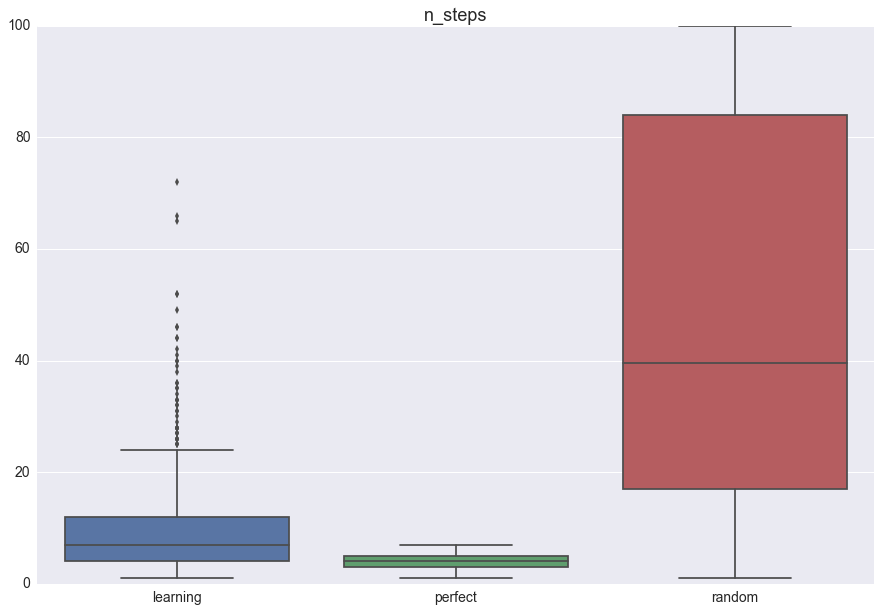

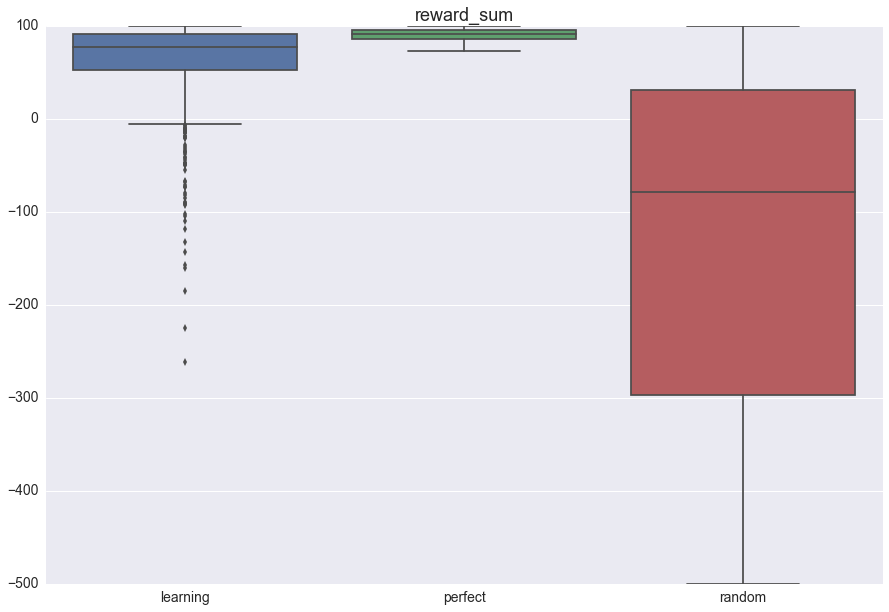

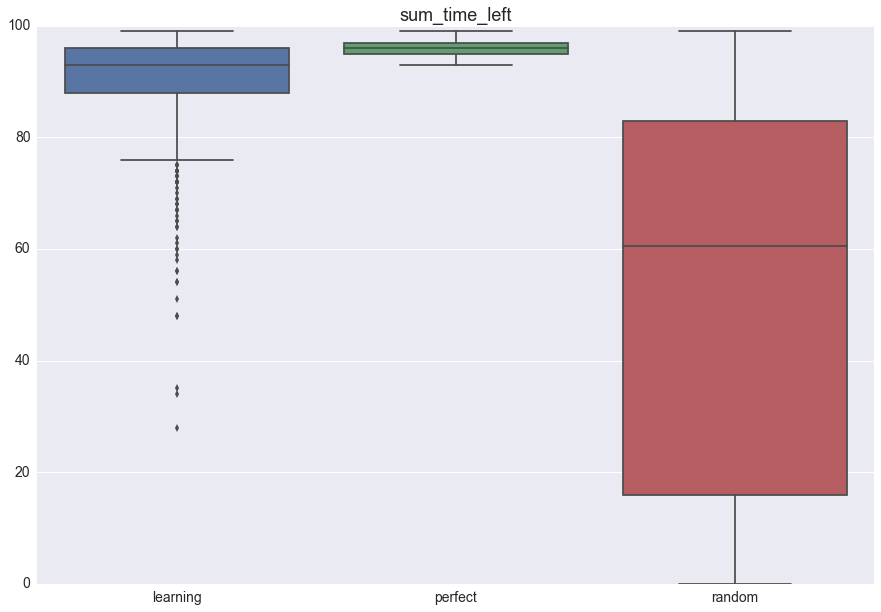

In [58]:
results = {'perfect': df_perfect, 'random': df_random, 'learning': df_learning}

panel = pd.Panel(results)

for column in df_perfect.columns:
    sns.boxplot(data=panel.minor_xs(column))
    plt.title(column)
    plt.show()
    plt.close()

### Learner's Progress

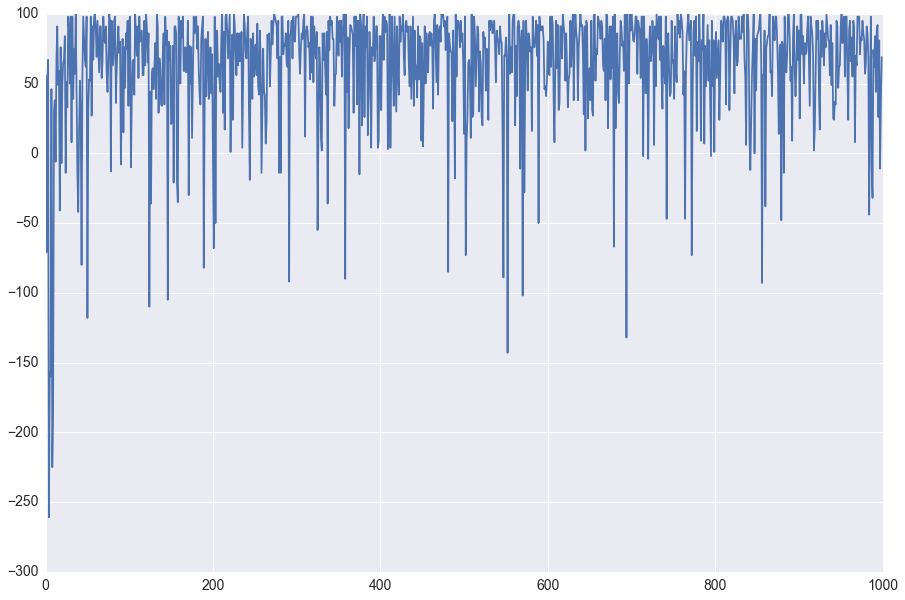

In [61]:
plt.plot(df_learning['reward_sum']);

Although the learner significantly improves after the first trials, I'm not sure there's enough evidence that it gets better after time. A larger number of trials may be needed to know for sure, and maybe I'll have to tweak the learner's parameters to make it more reliable over time.